# Titanic

This notebook is to explore the titanic dataset and produce a machine learning model that can predict which passengers survived or not depending on various features.

# Data preparation

**Option 1:**

In [30]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import seaborn as sn
import sqlalchemy

# set chart style
plt.style.use('ggplot')

# create database engine
engine = sqlalchemy.create_engine(
    url = 'postgresql://danielsuarez-mash@localhost/titanic_project?'
)

train = pd.read_sql('SELECT * FROM train', engine)
test = pd.read_sql('SELECT * FROM test', engine)
eg_submission = pd.read_sql('SELECT * FROM gender_submission', engine)

**Option 2:**

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# download competition data
api.competition_download_files('titanic')

# get datasets
with zipfile.ZipFile(file = 'titanic.zip') as my_zip:
    with my_zip.open(name = 'train.csv') as train_file:
        train = pd.read_csv(train_file)
    with my_zip.open(name = 'test.csv') as test_file:
        test = pd.read_csv(test_file)
    with my_zip.open(name = 'gender_submission.csv') as gender_sub:
        eg_submission = pd.read_csv(gender_sub)

# Exploratory Data Analysis

In [31]:
train.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,None,S


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    float64
 7   parch        891 non-null    float64
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 83.7+ KB


In [33]:
train.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5, 0, 'Survived (0 false, 1 true)')

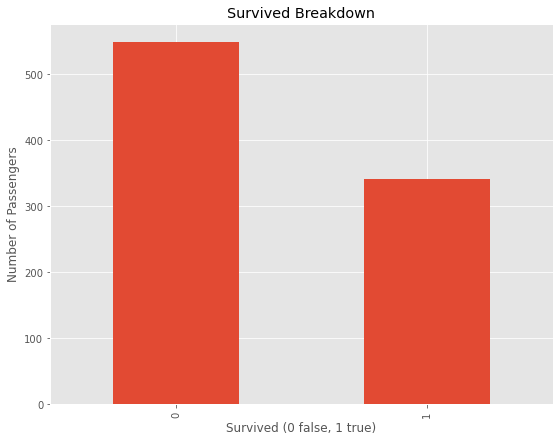

In [35]:
train['survived'].value_counts().plot(kind = 'bar', figsize = (9, 7))
plt.title('Survived Breakdown')
plt.ylabel('Number of Passengers')
plt.xlabel('Survived (0 false, 1 true)')

**Analysis steps**

1. What columns are useful for helping to predict survival?
2. What missing value strategy is best for each feature?
3. What feature engineering is needed to help predict survival?

## What columns are useful for helping to predict survival?

### Tableau Dashboard

In [36]:
%%html
<div class='tableauPlaceholder' id='viz1664994740575' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ti&#47;titanic_dashboard_16640445565300&#47;AgeSexvsSurvived_1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='titanic_dashboard_16640445565300&#47;AgeSexvsSurvived_1' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ti&#47;titanic_dashboard_16640445565300&#47;AgeSexvsSurvived_1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-GB' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1664994740575');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Pclass

From the chart below, we can see a clear rise in the survival rate with Pclass. This might indicate that wealthier passengers with a 1st class ticket were prioritised in some way during the evacuation. However, there isn't enough evidence to suggest causality.

Text(0, 0.5, 'Percentage (%)')

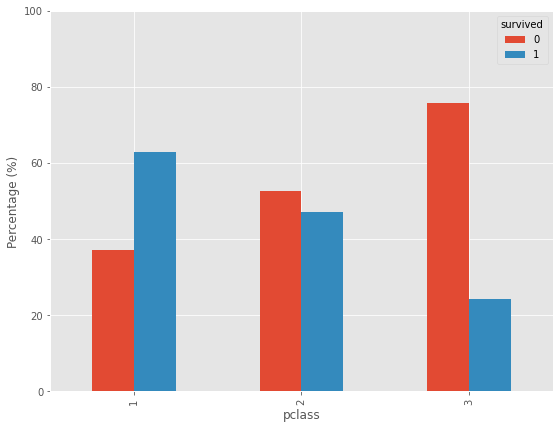

In [38]:
pclass_pct = (train.groupby(['pclass', 'survived']).passengerid.count() / train.groupby(['pclass', 'survived']).passengerid.count().unstack().sum(axis = 'columns'))*100
pclass_pct.unstack().plot(kind = 'bar', figsize = (9,7))
plt.ylim(bottom = 0, top = 100)
plt.ylabel('Percentage (%)')

### Sex

The chart below shows us that a much higher proportion of females survived the disaster. This is in line with reports that females were prioritised during the evacuation.

Text(0, 0.5, 'Percentage (%)')

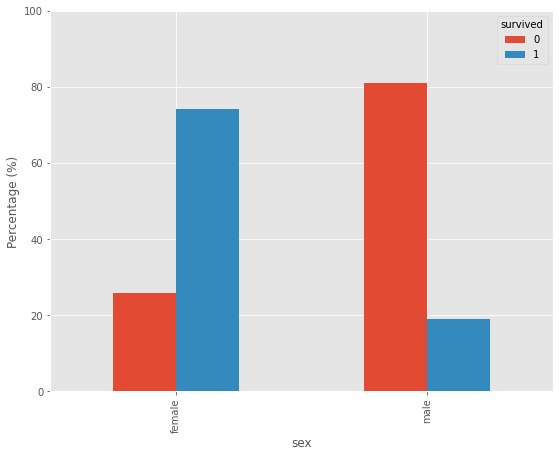

In [40]:
sex_pct = (train.groupby(['sex', 'survived']).passengerid.count() / train.groupby(['sex', 'survived']).passengerid.count().unstack().sum(axis = 'columns'))*100
sex_pct.unstack().plot(kind = 'bar', figsize = (9,7))
plt.ylim(bottom = 0, top = 100)
plt.ylabel('Percentage (%)')

### Age

Below we can see that young children were prioritised. Those aged between 15 and 30 were the least likely to survive. And the chance of survival gradually increases with age from there. From this, one could suggest young people were left behind as they were the strongest and could perhaps wait for help for longer. But this help probably didn't arrive, leading to their death.

<AxesSubplot:xlabel='age', ylabel='Count'>

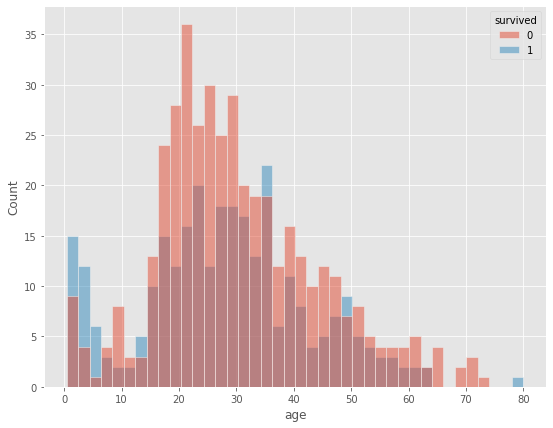

In [41]:
figure, axes = plt.subplots(figsize = (9, 7))

sn.histplot(data = train, x = 'age', hue = 'survived', bins = 40, ax = axes)

### SibSp - Number of siblings/spouses

From the chart below, most passengers had either 0 or 1 spouse/sibling. Those with 1 spouse/sibling were the most likely to survive. This might be because couples were harder to seperate. Or maybe those without siblings or spouses formed a lot of the young generation which suffered the worst survival rate.

Questions:

- What is the age distribution of passengers with SibSp = 0 or 1?

Text(0, 0.5, 'Percentage (%)')

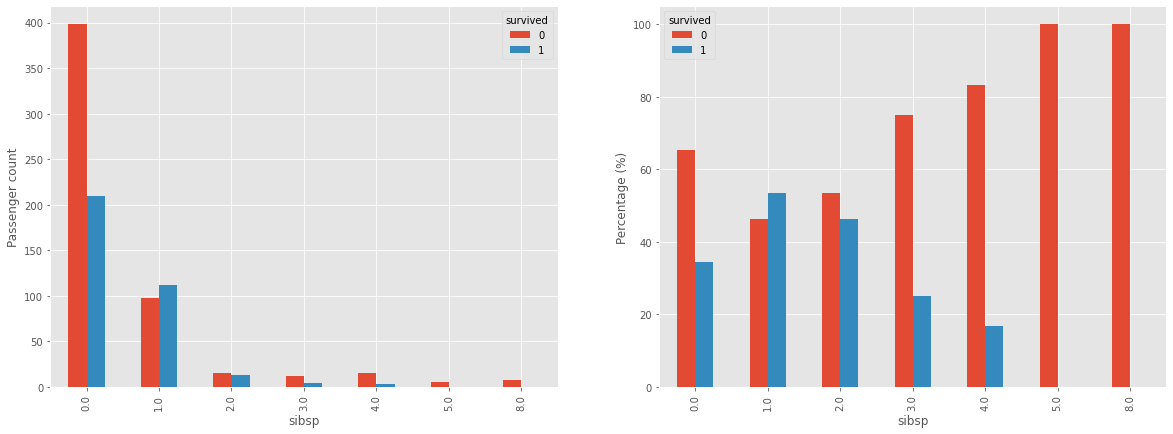

In [43]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7))

train.groupby(['sibsp', 'survived']).passengerid.count().unstack().plot(kind = 'bar', ax = ax1)
ax1.set_ylabel('Passenger count')

sibsp_pct = (train.groupby(['sibsp', 'survived']).passengerid.count() / train.groupby(['sibsp', 'survived']).passengerid.count().unstack().sum(axis = 'columns'))*100
sibsp_pct.unstack().plot(kind = 'bar', ax = ax2)
ax2.set_ylabel('Percentage (%)')

#### What is the age distribution of passengers with SibSp = 0 or 1?

The charts below show us that many of the passengers without a spouse or sibling were of the younger generation which suffered the worst survival rate. 

(0.0, 150.0)

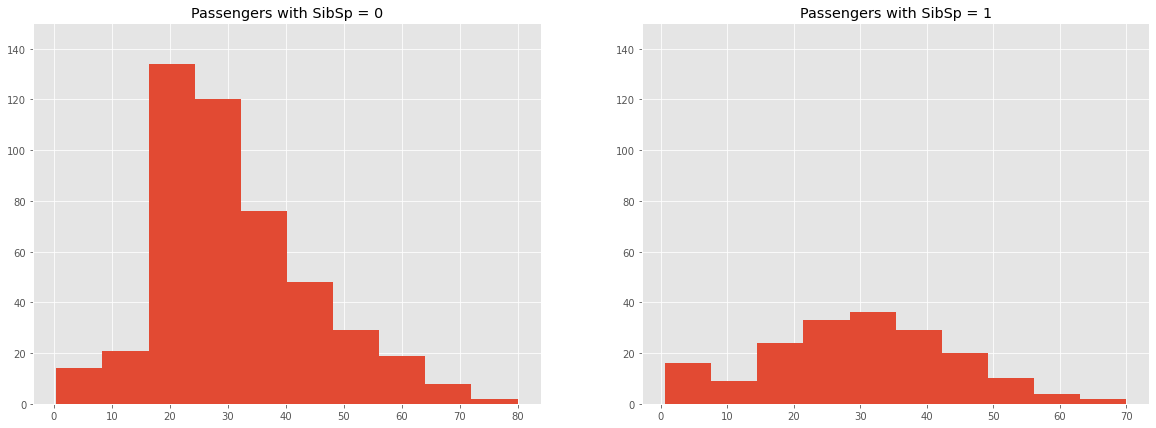

In [44]:
sibsp_0 = train[train['sibsp'] == 0]
sibsp_1 = train[train['sibsp'] == 1]

figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7))
sibsp_0['age'].hist(ax = ax1)
sibsp_1['age'].hist(ax = ax2)

ax1.set_title('Passengers with SibSp = 0')
ax2.set_title('Passengers with SibSp = 1')

ax1.set_ylim(top = 150)
ax2.set_ylim(top = 150)

### Parch - number of parents/children

Below we can see that those without a parent or child suffered the worst survival rate. Again, this may be because of the amount of young people who were without their parents or children. Those with a parent or child had around a 50/50 chance of survival which is possibly because children were seperated from their parents. 

<AxesSubplot:xlabel='parch'>

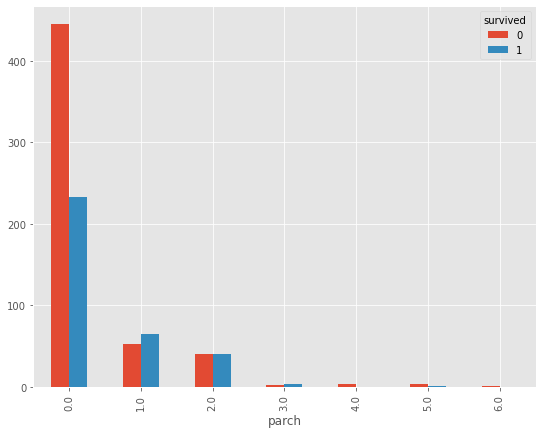

In [45]:
train.groupby(['parch', 'survived']).passengerid.count().unstack().plot(kind = 'bar', figsize = (9,7))

#### What is the age distribution for passengers with and without parents/children?

The graphs below confirm that many young people aged between 20 and 45 were without parents or children, and we know that they suffered the worst survival rate. The graph on the right shows that young children make up a large proportion of passengers with parents/children and we know they enjoyed the best survival rate.

(0.0, 150.0)

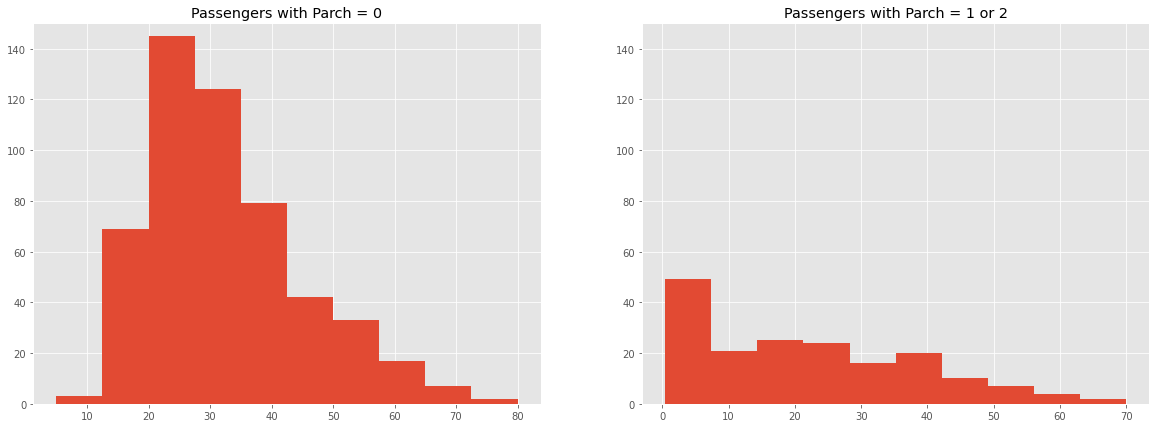

In [46]:
parch_0 = train[train['parch'] == 0]
parch_1_2 = train[train['parch'].isin([1,2])]

figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7))
parch_0['age'].hist(ax = ax1)
parch_1_2['age'].hist(ax = ax2)

ax1.set_title('Passengers with Parch = 0')
ax2.set_title('Passengers with Parch = 1 or 2')

ax1.set_ylim(top = 150)
ax2.set_ylim(top = 150)

# Model building

To keep things simple for now, we will build a simple maching learning model with the few features we've looked at so far.

The only concerns I have are that some of these features are correlated with one another. As we've seen, age is linked with the number of siblings/spouses and parents/children one has. How should this be dealt with? 

In the meantime, we will use the following features:

- Pclass
    - no further pre-processing required
- Sex
    - needs to be converted to numerical
- Age
    - no pre-processing required

## Pre-processing

**Missing Values** 

For now, only Age has missing values. It contains 714/891 values which should be sufficient enough for a machine learning model. We can try to implement imputation later on to see if the model improves. We will therefore drop rows with missing Age values.

In [47]:
# split the target variable
train_y = train['survived']
train_X = train.drop(columns = 'survived')

# put features in a dictionary
feature_dict = {'pclass': 0, 'age': 1, 'sex': 2}

In [48]:
# build class to filter attributes
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, feature_dict):
        
        self.feature_dict = feature_dict
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        # filter data using feature dictionary
        X_reduced = X[list(self.feature_dict.keys())]
        
        # convert to numpy array
        X_reduced = X_reduced.to_numpy()
        
        # impute Age feature
        age_imputer = SimpleImputer(strategy = 'mean')
        age_imputed = age_imputer.fit_transform(X_reduced[:, self.feature_dict['age']].reshape(-1,1))    # shape = (891 samples, 1 feature)
        X_reduced[:, self.feature_dict['age']] = age_imputed.reshape(1,-1)    # replace Age column with imputed Age column        
        
        # scale Age feature
        age_scaler = StandardScaler()
        age_scaled = age_scaler.fit_transform(X_reduced[:, self.feature_dict['age']].reshape(-1, 1))
        X_reduced[:, self.feature_dict['age']] = age_scaled.reshape(1, -1)
        
        # ordinal encode Sex feature
        sex_encoder = OrdinalEncoder()
        sex_encoded = sex_encoder.fit_transform(X_reduced[:, self.feature_dict['sex']].reshape(-1,1))    # shape = (891 samples, 1 feature)
        X_reduced[:, self.feature_dict['sex']] = sex_encoded.reshape(1,-1)    # replace Age column with imputed Age column
        
        return X_reduced

In [49]:
processor_train = PreProcessor(feature_dict = feature_dict)
train_prepared = processor_train.fit_transform(train_X)
train_prepared

array([[3, -0.5924805998028931, 1.0],
       [1, 0.6387890120425208, 0.0],
       [3, -0.2846631968415396, 0.0],
       ...,
       [3, 0.0, 0.0],
       [1, -0.2846631968415396, 1.0],
       [3, 0.17706290760049057, 1.0]], dtype=object)

## Model selection

For now, let's implement a logistic regression model.

## Fitting a model

In [50]:
from sklearn.linear_model import LogisticRegression

# create algorithm instance
log_reg = LogisticRegression()

# train the model on the data
log_reg.fit(train_prepared, train_y)

LogisticRegression()

In [51]:
# look at examples
num_examples = 20
some_data = train_prepared[:num_examples]
example_preds = log_reg.predict(some_data)

print('Predictions for first {} passengers are:'.format(num_examples), example_preds)
print('True labels for first {} passengers are:'.format(num_examples), train_y[:num_examples].to_numpy())

Predictions for first 20 passengers are: [0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1]
True labels for first 20 passengers are: [0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1]


## Model evaluation

We have a working model. How does it perform? Let's start off with accuracy as our performance metric. Accuracy means the fraction of predictions which were correct.

In [52]:
from sklearn.model_selection import cross_val_score

# cross validation
accuracy_scores = cross_val_score(estimator = log_reg, 
                                  X = train_prepared, 
                                  y = train_y, 
                                  scoring = 'accuracy',
                                  cv = 5)
accuracy_scores

array([0.78212291, 0.78651685, 0.79775281, 0.7752809 , 0.79775281])

# Submit predictions on test set

In [53]:
make_submission = False

if make_submission == True:
    # preprocess test set
    processor_test = PreProcessor(feature_dict = feature_dict)
    test_prepared = processor_test.fit_transform(test)

    # make predictions
    preds_test = log_reg.predict(test_prepared)

    # put submission together
    submission = np.c_[test['passengerId'].to_numpy(), preds_test]
    submission_pandas = pd.DataFrame(submission[:,1], index = submission[:,0], columns = ['Survived'])
    submission_pandas.index.name = 'PassengerId'
    submission_pandas.to_csv('submission.csv')

# submit predictions
api.competition_submit(file_name = 'submission.csv', message = 'standardised Age', competition = 'titanic')

# see results
!kaggle competitions submissions titanic

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.77k/2.77k [00:01<00:00, 1.85kB/s]


fileName               date                 description         status    publicScore  privateScore  
---------------------  -------------------  ------------------  --------  -----------  ------------  
submission.csv         2022-10-06 22:49:14  standardised Age    pending                              
submission.csv         2022-09-23 22:37:03  standardised Age    complete  0.75598                    
submission.csv         2022-09-23 22:36:33  titanic_submission  complete  0.75598                    
submission.csv         2022-09-23 21:37:48  titanic_submission  complete  0.75837                    
submission.csv         2022-09-23 21:25:52  titanic_submission  error                                
gender_submission.csv  2021-01-26 18:59:58                      complete  0.76555                    
